### 목표 : 미니배치기반 기계학습 진행 실습
- 확률적경사하강법 기반의 알고리즘 적용 모델
- 데이터의 처음부터 끝까지(에포크) 학습 후 가중치(w)와 절편(b) 업데이트 하는 방식에서 에포크를 미니배치 크기만큼
    나누어서 학습 후 가중치(w)와 절편(d)업데이트 진행 함
- 장점
    * 온라인 학습 즉, 점진적 학습 가능 => partial_fit() : 기존 모델에 추가로 1에포크 학습
    * 기존의 다른 모델보다 속도 빠름 => 랜덤으로 한개 데이터 추출 후 학습 진행
    * 조기 학습 중단 설정 가능
- 단점
    * 전체 학습보다 정확도는 떨어질 수 있음!

[1] 모듈 로딩 및 데이터 준비 <hr>

In [297]:
# 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt

data = '../data/fish.csv'

In [298]:
# 데이터 로딩
fishDF = pd.read_csv(data)
fishDF

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,Smelt,12.2,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,14.3,15.2,2.8728,2.0672


[2] 데이터 전처리 => 학습을 위한 가공 <hr>

[2-1] 피쳐/ 타겟 분리

In [299]:
featureDF = fishDF[fishDF.columns[1:]]
targetDF = fishDF['Species']
print(f'피쳐 => {featureDF.shape}, 타겟 => {targetDF.shape}')

피쳐 => (159, 5), 타겟 => (159,)


[2-2] 학습/ 테스트용 데이터셋 분리

In [300]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, stratify=targetDF, 
                                                    random_state=41)

In [301]:
print(f'[훈련용] => {X_train.shape}, {y_train.shape}')
print(f'[테스트용] => {X_test.shape}, {y_test.shape}')

[훈련용] => (119, 5), (119,)
[테스트용] => (40, 5), (40,)


[2-3] 피쳐 => 스케일링

In [302]:
from sklearn.preprocessing import StandardScaler


In [303]:
sdScaler = StandardScaler()
sdScaler.fit(X_train)

StandardScaler()

In [304]:
# 훈련용 데이터셋 스케일링
scaled_X_train=sdScaler.transform(X_train)
# 테스트용 데이터셋 스케일링
scaled_X_test=sdScaler.transform(X_test)

[3] 학습 진행 <hr>
- 학습 방법 : 확률적경사하강법(SGD) 기반의 분류

In [322]:
# 모델 인스턴스 생성
from sklearn.linear_model import SGDClassifier
# n_iter_no_change = 최적의 학습 횟수 정하기
model1 = SGDClassifier(random_state=41, verbose=0, loss='log_loss', alpha=0.001)        # 모델만들때 랜덤이 정해진다
model1.fit(scaled_X_train, y_train)

SGDClassifier(alpha=0.001, loss='log_loss', random_state=41)

과대적합 : feature에 너무 잘 맞는 것(fit), feature에 곱해지는 가중치(w)를 낮춰줘야 함 -> alpha값을 늘린다 -> 규제가 쎄게 들어감

In [323]:
train_score1 = model1.score(scaled_X_train, y_train)
test_score1 = model1.score(scaled_X_test, y_test)

In [324]:
print(f'[기본 SGD] 학습 점수 : {train_score1}, 테스트 점수 : {test_score1}')

[기본 SGD] 학습 점수 : 0.865546218487395, 테스트 점수 : 0.8


In [308]:
# 학습 후 설정된 파라미터 즉 모델 파라미터
print(f'n_iter_: {model1.n_iter_}')

n_iter_: 197


- 1에포크씩 점진적으로 학습 진행 => partial_fit()

In [309]:
# 모델 인스턴스 생성
model2 = SGDClassifier(loss='log_loss')
model2.partial_fit(scaled_X_train, y_train, y_train.unique())         # 랜덤으로 뽑는다.

SGDClassifier(loss='log_loss')

In [325]:
type(y_train.unique() )

numpy.ndarray

In [310]:
y_train.unique()        # class가 된다

array(['Smelt', 'Whitefish', 'Bream', 'Roach', 'Perch', 'Parkki', 'Pike'],
      dtype=object)

In [311]:
train_score2 = model2.score(scaled_X_train, y_train)
test_score2 = model2.score(scaled_X_test, y_test)

In [312]:
print(f'[기본 SGD] 학습 점수 : {train_score2}, 테스트 점수 : {test_score2}')

[기본 SGD] 학습 점수 : 0.6554621848739496, 테스트 점수 : 0.625


In [313]:
train_score, test_score = [],[]
deathcount = 0
for n in range(1,101):
    model2.partial_fit(scaled_X_train, y_train, y_train.unique())
    train_score2 = model2.score(scaled_X_train, y_train)
    test_score2 = model2.score(scaled_X_test, y_test)
    print(f'[{n}번학습] [기본 SGD] 학습 점수 : {train_score2}, 테스트점수 : {test_score2}')
    train_score.append(train_score2)
    test_score.append(test_score2)
    if (test_score2>=0.9) and (abs(test_score2-train_score2)>=0.03):
        deathcount += 1
        if deathcount>10:
            break

[1번학습] [기본 SGD] 학습 점수 : 0.7478991596638656, 테스트점수 : 0.8
[2번학습] [기본 SGD] 학습 점수 : 0.7478991596638656, 테스트점수 : 0.625
[3번학습] [기본 SGD] 학습 점수 : 0.7983193277310925, 테스트점수 : 0.625
[4번학습] [기본 SGD] 학습 점수 : 0.773109243697479, 테스트점수 : 0.725
[5번학습] [기본 SGD] 학습 점수 : 0.8235294117647058, 테스트점수 : 0.825
[6번학습] [기본 SGD] 학습 점수 : 0.8067226890756303, 테스트점수 : 0.85
[7번학습] [기본 SGD] 학습 점수 : 0.6974789915966386, 테스트점수 : 0.625
[8번학습] [기본 SGD] 학습 점수 : 0.8571428571428571, 테스트점수 : 0.75
[9번학습] [기본 SGD] 학습 점수 : 0.8067226890756303, 테스트점수 : 0.775
[10번학습] [기본 SGD] 학습 점수 : 0.8067226890756303, 테스트점수 : 0.725
[11번학습] [기본 SGD] 학습 점수 : 0.6386554621848739, 테스트점수 : 0.575
[12번학습] [기본 SGD] 학습 점수 : 0.8823529411764706, 테스트점수 : 0.825
[13번학습] [기본 SGD] 학습 점수 : 0.8235294117647058, 테스트점수 : 0.7
[14번학습] [기본 SGD] 학습 점수 : 0.8067226890756303, 테스트점수 : 0.825
[15번학습] [기본 SGD] 학습 점수 : 0.8487394957983193, 테스트점수 : 0.725
[16번학습] [기본 SGD] 학습 점수 : 0.7983193277310925, 테스트점수 : 0.7
[17번학습] [기본 SGD] 학습 점수 : 0.8907563025210085, 테스트점수 : 0.8
[18번학습] [기본 SGD] 

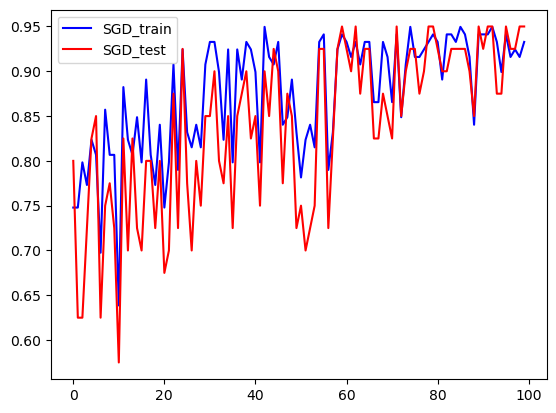

In [314]:
# 시각화
plt.plot(train_score, 'b-',label='SGD_train')
plt.plot(test_score, 'r-',label='SGD_test')
plt.legend()
plt.show()

In [315]:
test_score.index(max(test_score))       # 학습횟수 : +1일때 최대가 됨

59